## Scikit-Learn, Regression, and PCA, and still more regression.

In [2]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
from cycler import cycler
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['axes.prop_cycle'] = (cycler('color', dark2_colors))
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [3]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
abbrev_states_dict = {v: k for k, v in states_abbrev_dict.items()}

### First, a bit about scikit-learn

The structure of scikit-learn:

Some of the following text is taken from the scikit-learn API paper: http://arxiv.org/pdf/1309.0238v1.pdf

>All objects within scikit-learn share a uniform common basic API consisting of
three complementary interfaces: an estimator interface for building and ﬁtting
models, a predictor interface for making predictions and a transformer interface
for converting data.

>The estimator interface is at the core of the library. It deﬁnes instantiation
mechanisms of objects and exposes a ***fit*** method for learning a model from
training data. All supervised and unsupervised learning algorithms (e.g., for
classiﬁcation, regression or clustering) are oﬀered as objects implementing this
interface. Machine learning tasks like feature extraction, feature selection or
dimensionality reduction are also provided as estimators.



An example along these lines:

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
If one changes classifiers, say, to a Random Forest classifier, one would simply replace `LogisticRegression()` in the snippet above by `RandomForestClassifier()`.

>The **predictor** interface extends the notion of an estimator by adding a predict
method that takes an array `X_test` and produces predictions for `X_test`, based on
the learned parameters of the estimator. In the case of
supervised learning estimators, this method typically returns the predicted labels or values computed by the model. Some unsupervised learning estimators may also implement the predict interface, such as k-means, where the predicted values are the cluster labels.

    clf.predict(X_test)

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a **transformer** interface which deﬁnes a transform method. It takes as input some new data `X_test` and yields
as output a transformed version of `X_test`. Preprocessing, feature selection,
feature extraction and dimensionality reduction algorithms are all provided as
transformers within the library.

This is usually done via the `fit_transform` method. For example, to do a PCA:

    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)
    
The training set here is "fit" to find the PC components, and then then transformed. Since `pca.fit()` by itself changes the `pca` object, if we want to transform other data using the same transformation we simply call `transform` subsequently.

Finally, for now, there is the concept of a meta-estimator, which behaves quite similarly to standard estimators, but allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    from sklearn.multiclass import OneVsOneClassifier
    clf=OneVsOneClassifier(LogisticRegression())

>In scikit-learn, model selection is supported in two distinct meta-estimators,
GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic
or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

We shall use this latter functionality soon (and you have seen an example of it in HW2).

From: http://nbviewer.ipython.org/urls/raw.github.com/jakevdp/sklearn_scipy2013/master/rendered_notebooks/02.1_representation_of_data.ipynb

>Most machine learning algorithms implemented in scikit-learn expect data to be stored in a two-dimensional array or matrix. The arrays can be either numpy arrays, or in some cases scipy.sparse matrices. The size of the array is expected to be [n_samples, n_features]

To get a grip on how to do machine learning with scikit-learn, it is worth working through the entire set of notebooks at:
https://github.com/jakevdp/sklearn_pycon2013 . These go relatively fast, are fun to read.
The repository at https://github.com/jakevdp/sklearn_scipy2013 has more advanced notebooks. The `rendered_notebooks` folder here is useful with worked-out examples.

### PART 1: Linear Regression with a touch of PCA.

We'll see an example of the concepts mentioned above by considering a linear regression problem. Let us load the census data set.

In [4]:
census_data = pd.read_csv("./data/census_demographics.csv")
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,ALABAMA,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
1,ALASKA,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
2,ARIZONA,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
3,ARKANSAS,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
4,CALIFORNIA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


Clean the data set, and have it indexed by the state abbrev.

In [5]:
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s

census_data["State"] = census_data.state.map(capitalize)

del census_data["state"]

census_data['State'] = census_data['State'].replace(abbrev_states_dict)
census_data.set_index("State", inplace=True)
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
State,,,,,,,,,,,,
AL,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
AK,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
AZ,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
AR,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
CA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


We use a SPLOM to visualize some columns of this dataset. In Panda's the SPLOM is a one-liner.

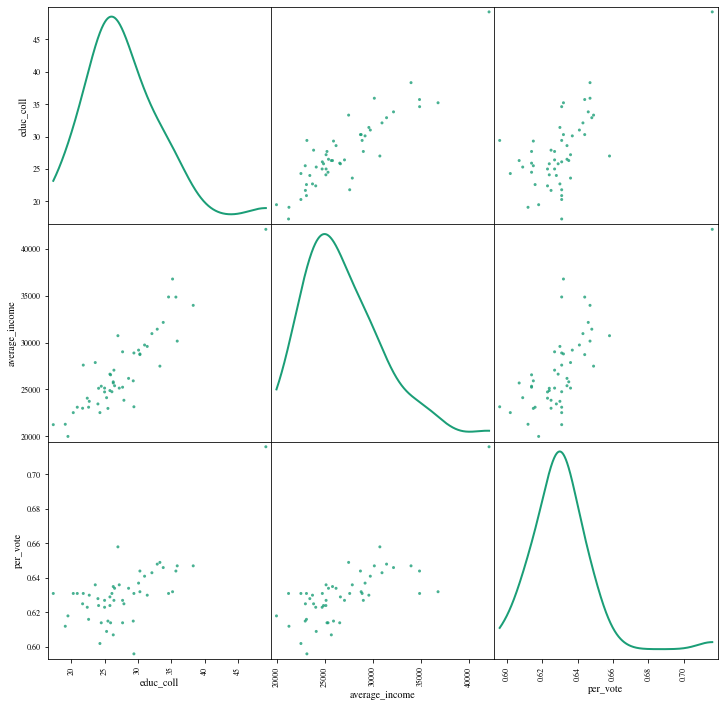

In [6]:
smaller_frame=census_data[['educ_coll', 'average_income', 'per_vote']]

from pandas.plotting import scatter_matrix

axeslist = scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

Notice how `average_income` seems to have a strong correlation with `educ_coll`. Lets try and regress the former against the latter. One might expect that the average income is higher in states which have "better" education systems and send more students to college. First lets confirm our intuition by seeing the co-relations.

In [7]:
smaller_frame.corr()

,educ_coll,average_income,per_vote
educ_coll,1.000000,0.894066,0.670977
average_income,0.894066,1.000000,0.732703
per_vote,0.670977,0.732703,1.000000


We carry out the regression, first standardizing our variables. This is strictly not necessary, but we are doing it as we wish to play around with PCA. Since `scikit-learn` wants a `n_sample` rows times `n_features` matrix, we need to reshape the `x` variable. We store both an `_vec` variable, which is easier to plot with, as well as the reshaped variable. 

In [9]:
from sklearn.linear_model import LinearRegression

X_HD = smaller_frame[['educ_coll', 'average_income']].values
X_HDn = (X_HD - X_HD.mean(axis=0)) / X_HD.std(axis=0)

educ_coll_std_vec = X_HDn[:,0]
educ_coll_std = educ_coll_std_vec.reshape(-1,1)
average_income_std_vec = X_HDn[:,1]
average_income_std = average_income_std_vec.reshape(-1,1)

We split the data into a training set and a testing set. By default, 25% of the data is reserved for testing. This is the first of multiple ways that we will see to do this.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(educ_coll_std, average_income_std_vec)

We use the training set for the fit, and find what our predictions ought to be on both the training and test set.

In [12]:
clf1 = LinearRegression()
clf1.fit(X_train, y_train)

predicted_train = clf1.predict(X_train)
predicted_test = clf1.predict(X_test)

trains = X_train.reshape(1,-1).flatten()
tests = X_test.reshape(1,-1).flatten()

print (clf1.coef_, clf1.intercept_)

[0.87315366] -0.04847760778244621


We plot the scatter against the fit for both training and test data.

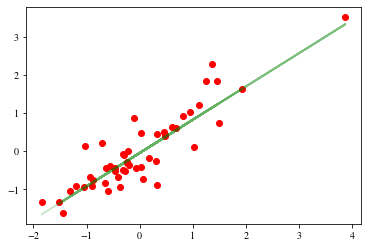

In [16]:
plt.scatter(educ_coll_std_vec, average_income_std_vec,c='r')
plt.plot(trains, predicted_train, c='g', alpha=0.5)
plt.plot(tests, predicted_test, c='g', alpha=0.2);

We then look at the residuals, again on both sets.

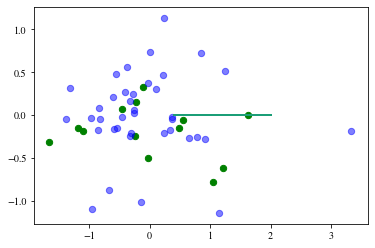

In [18]:
plt.scatter(predicted_test, predicted_test - y_test, c='g', s=40)
plt.scatter(predicted_train, predicted_train - y_train, c='b', s=40, alpha=0.5)
plt.plot([0.4,2],[0,0]);

We ask scikit-learn to spit out the $R^2$. If you'd like R-style detailed information about your regression, use `statsmodels` instead. 

In [19]:
clf1.score(X_train, y_train), clf1.score(X_test, y_test)

(0.7580599196955567, 0.8855535844819593)

#### Doing a PCA on the data

Lets take the standardized data and do a 2-D PCA on it. Here we do not seek to accomplish a dimensional reduction, but to understand the variance structure of the data.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X_HDn)

print(pca.explained_variance_ratio_)

[0.94703283 0.05296717]


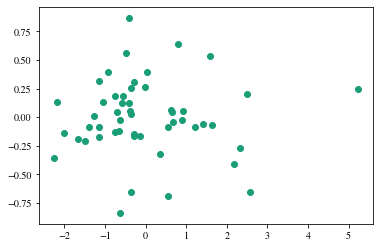

In [21]:
plt.scatter(X[:, 0], X[:, 1])

Since the first component is so large, lets only keep it, and then reconstruct the original data from only this component, setting the others to 0.

In [22]:
pca1 = PCA(n_components=1) # only keep one dimension!
X_E = pca1.fit_transform(X_HDn)
X_reconstructed = pca1.inverse_transform(X_E)

We plot the reconstructed education(x) and income(y) from the first principal component, in blue.

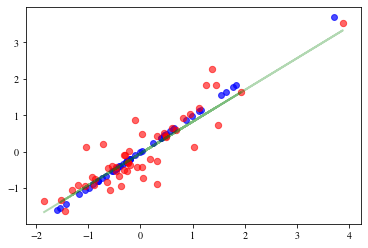

In [24]:
plt.scatter(X_reconstructed[:,0], X_reconstructed[:,1],c='b', s=35, alpha=0.7)
plt.scatter(educ_coll_std_vec, average_income_std_vec, s=40, c='r', alpha=0.6)
plt.plot(trains, predicted_train, c='g', alpha=0.3)
plt.plot(tests, predicted_test, c='g', alpha=0.3);

We see that the principal component line is steeper as we saw in class. The principle behind the projections is captured below in this plot from stack overflow that HP showed in class.

![](files/data/pcavsfit.png)

>YOUR TURN NOW

Regress the variables in the other direction: ie the `educ_coll` against the `average_income`. This might feel strange to you but remember regression is not about CAUSALITY, only about CORRELATION.

In [26]:
#your code here
clf2 = LinearRegression()
clf2.fit(average_income_std, educ_coll_std_vec)
print (clf2.coef_,clf2.intercept_)

[0.89406566] 7.035899557939931e-17


Create a similar scatterplot and fit line for this regression.

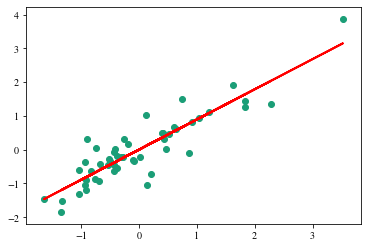

In [28]:
plt.plot(average_income_std_vec, clf2.predict(average_income_std), c='r')
plt.scatter(average_income_std_vec, educ_coll_std_vec)

### Part 2: Logistic Regression

From http://www.edwardtufte.com/tufte/ebooks, in "Visual and Statistical Thinking: 
Displays of Evidence for Making Decisions":

>On January 28, 1986, the space shuttle Challenger exploded and seven astronauts died because two rubber O-rings leaked. These rings had lost their resiliency because the shuttle was launched on a very cold day. Ambient temperatures were in the low 30s and the O-rings themselves were much colder, less than 20F.

>One day before the flight, the predicted temperature for the launch was 26F to 29F. Concerned that the rings would not seal at such a cold temperature, the engineers who designed the rocket opposed launching Challenger the next day.

But they did not make their case persuasively, and were over-ruled by NASA.

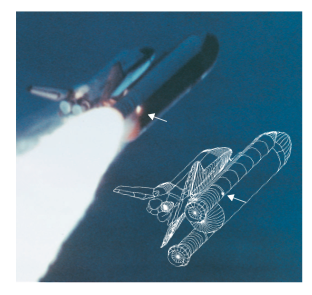

In [29]:
from IPython.display import Image as Im
from IPython.display import display
Im('./data/shuttle.png')

The image above shows the leak, where the O-ring failed.

We have here data on previous failures of the O-rings at various temperatures.

In [30]:
data=np.array([[float(j) for j in e.strip().split()] for e in open("./data/chall.txt")])
data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

Lets plot this data

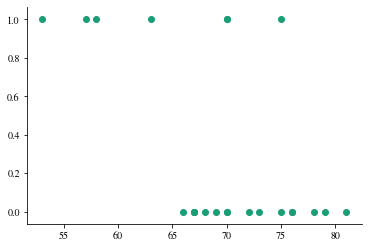

In [31]:
temps, pfail = data[:,0], data[:,1]
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)

1 represents failure. This graph has a classic sigmoid shape, so one might expect logistic regression to work. Furthermore, we do want to find the probability of failure and make predictions from there.

Logistic regression is carried out in the same way as linear. However, there is the "pesky" matter of setting the regularization co-efficient `C`. We havent still covered this in class, so what we do today is just a preview, but its nonetheless important to see.

The default `C` in sklearn is 1.The meaning of `C` is: the larger the `C`, the lesser the regularization. The smaller the `C` the higher the regularization.

What does regularization do? Larger regularizations penalize the values of regression coefficients. Smaller ones let the co-efficients range widely. Thus, larger `C` let the regression coefficients range widely. Scikit-learn bakes in two penalties: a l2 penalty which penalizes the sum of the squares of the coefficients, and a l1 penalty which penalizes the sum of the absolute values.

The reason for doing this is that is there are many co-variates we use for our prediction: we want to make sure we can get away with the simplest model that describes our data, even if that might increase the bias side of the bias-variance tradeoff a bit.

Remember here, though, that we have just two co-efficents: an intercept, and the outside temperature. So we do not expect to need regularization much. Indeed lets set `C=1000`.

In [35]:
from sklearn.linear_model import LogisticRegression
reg=1000.
clf4 = LogisticRegression(C=reg, solver='lbfgs')
clf4.fit(temps.reshape(-1,1), pfail);

Lets make predictions, get the associated probabilities, and plot them. We create a new grid of temperatures to evaluate our predictions at. Note that we do not do a test/train split: we have only 23 data points, but need to shut down the launch if there is any doubt. (One wishes...)

In [38]:
tempsnew = np.linspace(20., 90., 15)

probs = clf4.predict_proba(tempsnew.reshape(-1,1))[:, 1]

predicts = clf4.predict(tempsnew.reshape(-1,1))

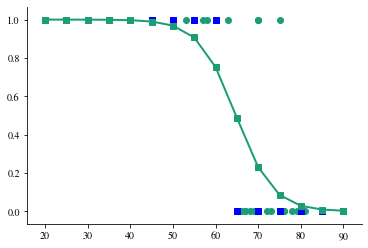

In [44]:
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='s', color="b");

We use pandas `crosstab` to write a table of prediction vs failure on the "training" set. As one might expect, the mislabellings come at the higher temperatures.

In [41]:
pd.crosstab(pfail, clf4.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


>YOUR TURN NOW

Carry out a Logistic Regression with scikit-learn's default value for `C`. Make a plot similar to the scatterplot above, and carry out the cross-tabulation. What happens?

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


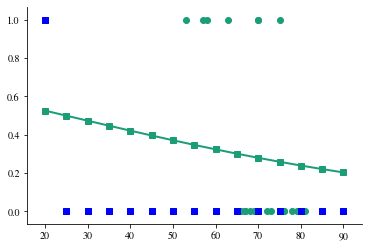

In [49]:
#your code here
clf4w = LogisticRegression()
clf4w.fit(temps.reshape(-1,1), pfail)
probsw = clf4w.predict_proba(tempsnew.reshape(-1,1))[:, 1]
predictsw = clf4w.predict(tempsnew.reshape(-1,1))
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
plt.plot(tempsnew, probsw, marker='s')
plt.scatter(tempsnew, predictsw, marker='s', color="b")

In [50]:
#your code here
pd.crosstab(pfail, clf4w.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
0.0,16
1.0,7


#### Logistic Regression with cross-validation

We now actually go ahead and to the train/test split. Not once but multiple times, on a grid search, for different values of `C`. For each `C`, we:

1. create `n_folds` folds. Since the data size is 23 here, and we have 5 folds, we roughly split the data into 5 folds of 4-5 values each, randomly. 
2. We then train on 4 of these folds, test on the 5th
3. We average the results of all such combinations
4. We move on to the next value of `C`, and find the optimal value that minimizes mean square error.
5. We finally use that value to make the final fit.

Notice the structure of the `GridSearchCV` estimator in `cv_optimize`.

In [58]:
from sklearn.linear_model import LogisticRegression
def fit_logistic(X_train, y_train, reg=0.0001, penalty="l2"):
    clf = LogisticRegression(C=reg, penalty=penalty, solver='lbfgs')
    clf.fit(X_train, y_train)
    return clf

from sklearn.model_selection import GridSearchCV

def cv_optimize(X_train, y_train, paramslist, penalty="l2", n_folds=10):
    clf = LogisticRegression(penalty=penalty, solver='lbfgs')
    parameters = {"C": paramslist}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, iid=False)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_

def cv_and_fit(X_train, y_train, paramslist, penalty="l2", n_folds=5):
    bp, bs = cv_optimize(X_train, y_train, paramslist, penalty=penalty, n_folds=n_folds)
    print ("BP,BS", bp, bs)
    clf = fit_logistic(X_train, y_train, penalty=penalty, reg=bp['C'])
    return clf

In [59]:
clf=cv_and_fit(temps.reshape(-1,1), pfail, np.logspace(-4, 3, num=100))

BP,BS {'C': 0.1788649529057435} 0.8766666666666666


In [60]:
pd.crosstab(pfail, clf.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


We plot our results, this time also marking in red the predictions on the "training" set.

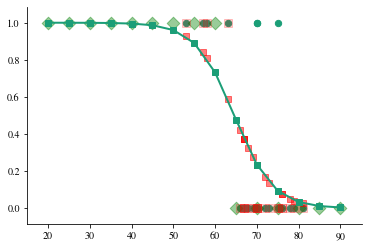

In [62]:
plt.scatter(temps, pfail, s=40)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
probs=clf.predict_proba(tempsnew.reshape(-1,1))[:,1]
predicts=clf.predict(tempsnew.reshape(-1,1))
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='D', color="green", s=80, alpha=0.4)
train_probs=clf.predict_proba(temps.reshape(-1,1))[:,1]
plt.scatter(temps, train_probs, marker='s', c='r', alpha=0.5, s=40)
train_predicts=clf.predict(temps.reshape(-1,1))
plt.scatter(temps, train_predicts, marker='s', c='r', alpha=0.2, s=80);

The failures in prediction are, exactly where you might have expected them to be, as before.

In [63]:
zip(temps,pfail, clf.predict(temps.reshape(-1,1)))

We note that the true story was even worse than our data made it out to be! We did not take the severity of the incidents into account. How could we have incorporated this severity into our analysis? (these images are taken from Tufte's booklet).

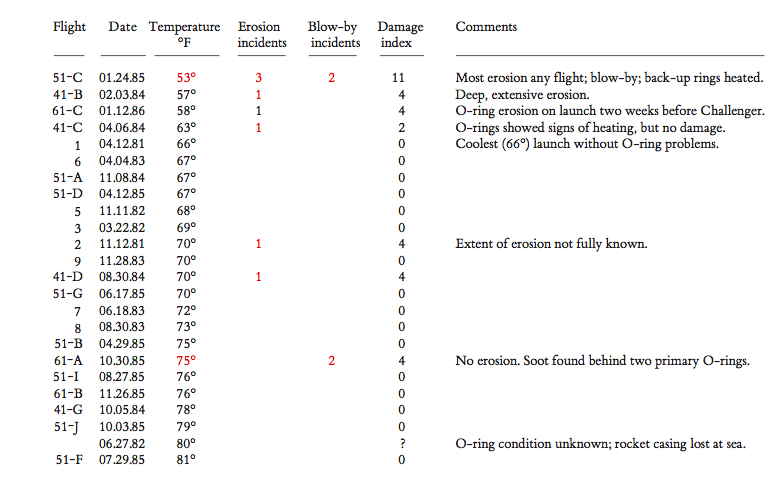

In [64]:
Im('./data/chall-table.png')

![](files/data/chall-damage.png)

### Part 3: PCA

In [65]:
from PIL import Image

You are an ATM and have to distinguish between cash and check. Its based on a check/drivers license separator at the yhat blog (http://blog.yhathq.com/posts/image-classification-in-Python.html), and a fair bit of code is obtained from there. This problem is a bit more interesting as there is more structure in the images. 

We standardize the size of the images:

In [67]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (322, 137)

def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = Image.open(filename)
    if verbose==True:
        print ("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [68]:
import os

checks_dir = "./data/images/images/checks/"
dollars_dir = "./data/images/images/dollars/"

def images(img_dir):
    return [img_dir+f for f in os.listdir(img_dir)]

checks = images(checks_dir)
dollars = images(dollars_dir)
images = checks+dollars
labels = ["check" for i in range(len(checks))] + ["dollar" for i in range(len(dollars))]
len(labels), len(images)

(87, 87)

Lets see what some of these images look like:

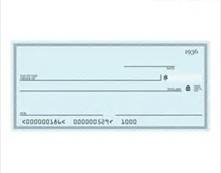

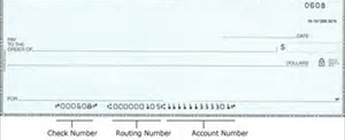

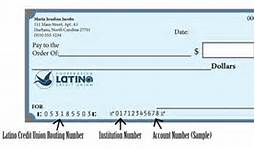

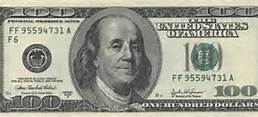

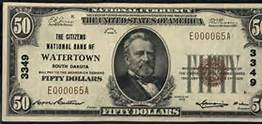

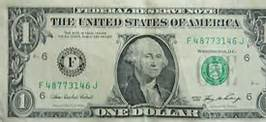

In [69]:
for i in range(3):
    display(Im(checks[i]))
for i in range(3):
    display(Im(dollars[i]))

What features might you use to distinguish the notes from the checks?

Here is an example of transforming an image into its R channel.

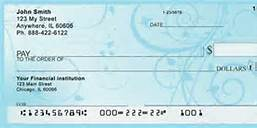

()


IndexError: too many indices for array

In [72]:
i0 = images[20]
display(Im(i0))
i0m = img_to_matrix(i0)
print(i0m.shape)

plt.imshow(i0m[:,1].reshape(137,322))

We do this for every image, flattening each image into 3 channels of 44114 pixels, for a total of 132342 features per image!

In [74]:
data = []

for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    data.append(img)

data = np.array(data)
data.shape

IndexError: tuple index out of range

In [75]:
y = np.where(np.array(labels)=="check", 1, 0)
y.shape

(87,)

We now carryout a 20D PCA, which captures 73% of the variance.

In [77]:
def do_pca(d,n):
    pca = PCA(n_components=n)
    X = pca.fit_transform(d)
    print (pca.explained_variance_ratio_)
    return X, pca

In [78]:
X20, pca20=do_pca(data,20)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [79]:
np.sum(pca20.explained_variance_ratio_)

NameError: name 'pca20' is not defined

Justfor kicks, because we can plot it, we'll do the 2D PCA

In [80]:
X2, pca2=do_pca(data,2)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [81]:
df = pd.DataFrame({"x": X2[:, 0], "y": X2[:, 1], "label":np.where(y==1, "check", "dollar")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
plt.legend()

NameError: name 'X2' is not defined

**Whoa**! What do we have here. A quick visual shows that 2Dims may be enough to allow for linear separation of checks from dollars, with 42% of the variance accounted for. It would be usefull for face recognition, but all we want to do is to split images into two classes, so its not actually that surpring. 

(For a notebook on face recognition, see:

http://nbviewer.ipython.org/urls/raw.github.com/jakevdp/sklearn_scipy2013/master/rendered_notebooks/05.1_application_to_face_recognition.ipynb.)

We provide some code to reconstruct, from the principal components, the images corresponding to them.

In [46]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)

def getRGB(o):
    size=322*137*3
    r=o[0:size:3]
    g=o[1:size:3]
    b=o[2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b

def getNC(pc, j):
    return getRGB(pc.components_[j])

def getMean(pc):
    m=pc.mean_
    return getRGB(m)

def display_from_RGB(r, g, b):
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    img = Image.fromarray(rgbArray)
    plt.imshow(np.asarray(img))
    ax=plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def display_component(pc, j):
    r,g,b = getNC(pc,j)
    return display_from_RGB(r,g,b)
    


And use these to see the first two PC's. It looks like the contrast difference between the presidential head and the surroundings is the main key to doing the classifying. The second PC seems to capture general darkness.

In [47]:
display_component(pca2,0)

In [48]:
display_component(pca2,1)

>YOUR TURN NOW

Do a 5 dimensional PCA, get the variance explanation, and display the components.

In [49]:
#your code here


In [50]:
#your code here


In [51]:
#your code here


In [52]:
display_from_RGB(*getMean(pca5))

#### Using a logistic clasifier

We provide our usual code adapted from the scikit-learn web site to show classification boundaries.

In [53]:
from matplotlib.colors import ListedColormap

def points_plot(Xtr, Xte, ytr, yte, clf):
    X=np.concatenate((Xtr, Xte))
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    f,ax = plt.subplots()
    # Plot the training points
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, cmap=cm_bright)
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte, cmap=cm_bright, marker="s", s=50, alpha=0.9)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)
    cs2 = ax.contour(xx, yy, Z, cmap=cm, alpha=.4)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax

Here we show a way of doing the train-test breakdown ourselves!

In [54]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.7
train_x, train_y = data[is_train], y[is_train]
test_x, test_y = data[is_train==False], y[is_train==False]

We *fit (find PC's) and transform* the training data, and then use the PC's to transform the test data.

In [55]:
pca = PCA(n_components=2)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

We then do a cross-validated logistic regression. Note the large amount of the regularization. Why do you think this is the case?

In [56]:
logreg = cv_and_fit(train_x, train_y, np.logspace(-4, 3, num=100))
pd.crosstab(test_y, logreg.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

In [57]:
logreg.coef_, logreg.intercept_

In [58]:
points_plot(train_x, test_x, train_y, test_y, logreg)

Lets try a "L1" penalty instead of "L2". this is strictly not a correct thing to do since PCA and L2 regularization are both rotationally invariant. However, lets see what happen to the co-efficients.

In [59]:
logreg_l1=cv_and_fit(train_x, train_y, np.logspace(-4, 3, num=100), penalty="l1")
pd.crosstab(test_y, logreg_l1.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

In [60]:
print logreg_l1.coef_, logreg_l1.intercept_

In [61]:
points_plot(train_x, test_x, train_y, test_y, logreg_l1)

Notice "L1" regularization supresses the internet and reduces the importance of the second dimension. If one wants to minimize non-zero coefficients, one uses "L1" regularization.

>YOUR TURN NOW

Carry out a 5 dimensional PCA and then a logistic rgression in both "l2" and "l1" modes. Create crosstabs and print co-efficents for both. What do you find?

In [62]:
#your code here


In [63]:
#your code here


In [64]:
#your code here


In [65]:
#your code here


In [66]:
#your code here
